# Are Calcium Signals Before and After Dosing Stastistically Distinct

In [1]:
using Pkg
Pkg.activate("..")
using DataFrames, DrWatson, HypothesisTests, LinearAlgebra, Plots, Query, SparseArrays, Statistics, StatsPlots
if haskey(ENV, "GKS_WSTYPE")
    delete!(ENV, "GKS_WSTYPE")
end;
include(srcdir("load.jl"));

Activating environment at `~/dglmoore/yuji/Project.toml`


In [2]:
df = let
        df = collect_results(datadir("info"));
        ef = hcat(select(df[1:-1,:], [:drug, :trial, :gh, :gw, :phase]),
                  DataFrame(gridsize=Int[],
                            lag=Int[],
                            mi=SparseMatrixCSC{Float64,Int64}[],
                            nnz=Int[],
                            eigen=Float64[])) |> disallowmissing!
        for row in eachrow(df)
            entry = Dict(:drug => row[:drug],
                         :trial => row[:trial],
                         :gh => row[:gh],
                         :gw => row[:gw],
                         :phase => row[:phase],
                         :gridsize => (row[:gh]*row[:gw])^2)
            for (i, m) in enumerate(row[:mi])
                A = linearize(m)
                Asparse = sparse(A)
                merge!(entry, Dict(:lag => i - 1,
                                   :mi => Asparse,
                                   :nnz => nnz(Asparse),
                                   :eigen => real(last(first(eigen(A))))))
                push!(ef, entry)
            end
        end
        ef
    end;

┌ Info: Scanning folder /home/ec2-user/dglmoore/yuji/data/info for result files.
└ @ DrWatson /home/ec2-user/.julia/packages/DrWatson/vLVOx/src/result_collection.jl:79
┌ Info: Added 108 entries.
└ @ DrWatson /home/ec2-user/.julia/packages/DrWatson/vLVOx/src/result_collection.jl:107


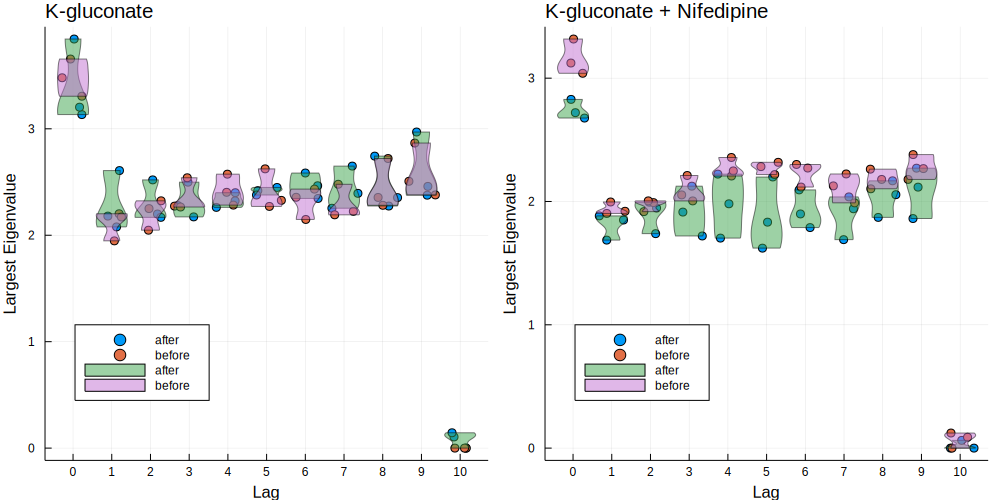

In [5]:
let frame = df |> @filter(_.gridsize == 30^4)
    kf = frame |> @filter(_.drug == "K-gluconate")
    knf = frame |> @filter(_.drug == "K-gluconate:Nifedipine")

    kplot = @df kf dotplot(:lag, :eigen, group=:phase, marker=(:circ, 4, 1.0))
    @df kf violin!(kplot, :lag, :eigen, group=:phase, α=0.5)
    
    knplot = @df knf dotplot(:lag, :eigen, group=:phase, marker=(:circ, 4, 1.0))
    @df knf violin!(knplot, :lag, :eigen, group=:phase, α=0.5)
    
    plot(kplot, knplot, layout=2, title=["K-gluconate" "K-gluconate + Nifedipine"], titleloc=:left,
         xlabel="Lag", xticks=0:11, ylabel="Largest Eigenvalue", size=(1000,500), legend=:bottomleft)
end

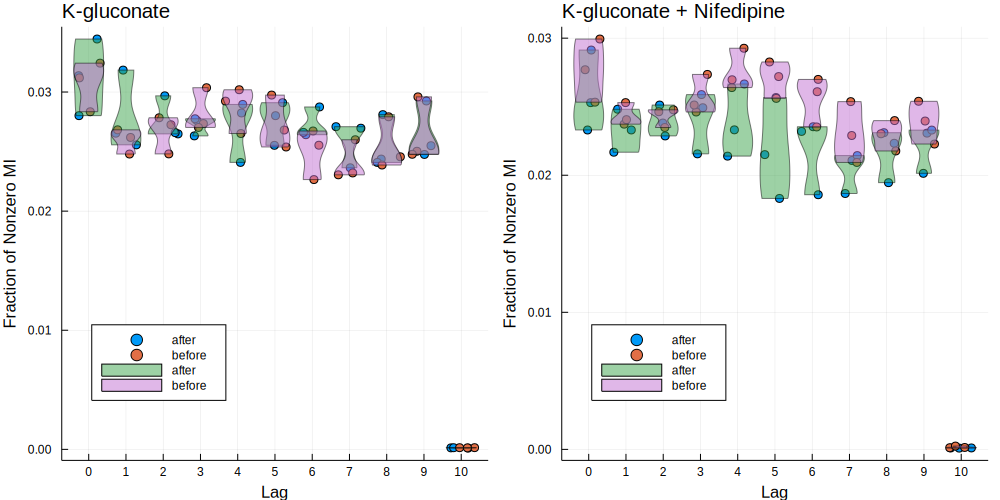

In [4]:
let frame = df |> @filter(_.gridsize == 30^4) |> @map({_.drug, _.lag, _.phase, fnnz = _.nnz / _.gridsize})
    kf = frame |> @filter(_.drug == "K-gluconate")
    knf = frame |> @filter(_.drug == "K-gluconate:Nifedipine")

    kplot = @df kf dotplot(:lag, :fnnz, group=:phase, marker=(:circ, 4, 1.0))
    @df kf violin!(kplot, :lag, :fnnz, group=:phase, α=0.5)
    
    knplot = @df knf dotplot(:lag, :fnnz, group=:phase, marker=(:circ, 4, 1.0))
    @df knf violin!(knplot, :lag, :fnnz, group=:phase, α=0.5)
    
    plot(kplot, knplot, layout=2, title=["K-gluconate" "K-gluconate + Nifedipine"], titleloc=:left,
         xlabel="Lag", xticks=0:11, ylabel="Fraction of Nonzero MI", size=(1000,500), legend=:bottomleft)
end

In [21]:
bootstrap(xs::AbstractArray, ys::AbstractArray) = mean(rand(xs, size(xs)...)) - mean(rand(ys, size(ys)...))
function bootstrap(xs::AbstractArray, ys::AbstractArray, N::Int, filt=isfinite)
    xnull, ynull = xs .- mean(xs), ys .- mean(ys)
    stats = [bootstrap(xnull, ynull) for _ in 1:N]
    stat = bootstrap(xs, ys)
    μ = mean(stats[filt.(stats)])
    a, b = if stat < μ
        stat, 2μ - stat
    else
        2μ - stat, stat
    end
    mean(stats .< a) + mean(stats .> b)
end

bootstrap (generic function with 3 methods)

In [22]:
withoutmi = select(df, :drug, :gh, :gw, :phase, :lag, :eigen);

In [70]:
eigenps = @time by(withoutmi, [:drug, :gh, :gw, :lag]) do gf
        before = filter(r -> r[:phase] == "before", gf)
        after = filter(r -> r[:phase] == "after", gf)
        (p = bootstrap(before.eigen, after.eigen, 10000000, s -> s < 1e10), )
    end;

487.827367 seconds (3.96 G allocations: 443.288 GiB, 19.35% gc time)


In [68]:
eigenps |> @filter(_.gh == 30 && _.gw == 30) |> DataFrame

,drug,gh,gw,lag,p
,String,Int64,Int64,Int64,Float64
1,K-gluconate:Nifedipine,30,30,0,0.0
2,K-gluconate:Nifedipine,30,30,1,0.00961
3,K-gluconate:Nifedipine,30,30,2,0.602511
4,K-gluconate:Nifedipine,30,30,3,0.365054
5,K-gluconate:Nifedipine,30,30,4,0.212014
6,K-gluconate:Nifedipine,30,30,5,0.0
7,K-gluconate:Nifedipine,30,30,6,0.0
8,K-gluconate:Nifedipine,30,30,7,0.027466
9,K-gluconate:Nifedipine,30,30,8,0.006615
